## Imports

In [1]:
import os
import random
import pandas as pd
import numpy as np
import json
import vk
from sklearn.cluster import KMeans
from sklearn.preprocessing import Normalizer
from sklearn.manifold import TSNE

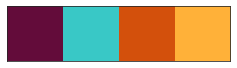

In [2]:
# Visualisation tools

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# set font size of labels on matplotlib plots
plt.rc('font', size=16)
# set style of plots
sns.set_style('white')
# define a custom palette
customPalette = ['#630C3A', '#39C8C6', '#D3500C', '#FFB139']
sns.set_palette(customPalette)
sns.palplot(customPalette)

The number of clusters is set to 2, for us trying to label accounts in terms "bot/non-bot".

In [3]:
N_CLUSTERS = 2
DATA_FOLDER = "data"
RAW_FOLDER = "raw"
INTERIM_FOLDER = "interim"

## Get the data

In [4]:
bots_fp = os.path.join("..", DATA_FOLDER, RAW_FOLDER, "2021_10_19.csv")
bots_df = pd.read_csv(bots_fp, index_col="Unnamed: 0")
bots = bots_df["ID"].to_list()
bots[:10]

['VK_107766587',
 'VK_114217055',
 'VK_11475787',
 'VK_115167994',
 'VK_115255023',
 'VK_115856486',
 'VK_11845346',
 'VK_119083272',
 'VK_122669009',
 'VK_127733082']

In [5]:
# We define train, test and validation datasets

val_fp = os.path.join("..", DATA_FOLDER, INTERIM_FOLDER, "accs_pt1.json")
test_fp = os.path.join("..", DATA_FOLDER, INTERIM_FOLDER, "accs_pt2.json")
train_fp = os.path.join("..", DATA_FOLDER, INTERIM_FOLDER, "accs_pt3.json")

with open(train_fp, "r") as handler:
    train = json.load(handler)
    
with open(test_fp, "r") as handler:
    test = json.load(handler)
    
with open(val_fp, "r") as handler:
    val = json.load(handler)

## Preprocess

We transform the scraped data to datasets, where each row describes an account with a vector of dimensionality 6. The parameteres gathered for this specific approach (visual) were: is the account active (not banned), was the user active in previous 24 hours, does the user have a web-site, number of friends of this user, number of blocked friends, number of gtoups to which the user belongs. We drop for EDA the accounts that were for some reason (maybe, becuase of timeout ban in VK) parsed without collecting information about befriended accounts.

In [6]:
def transform(entity):
    size = 0
    nodes = []
    dataset = []
    for k in entity:
        if entity[k][3]:
            size += 1
            nodes.append(k)
            dataset.append(entity[k])
    return dataset, nodes, size


train_dataset, train_nodes, train_size = transform(train)
test_dataset, test_nodes, test_size = transform(test)
val_dataset, val_nodes, val_size = transform(val)

train_size, test_size, val_size

(425, 619, 208)

We scale datasets.

In [7]:
normalizer = Normalizer()

train_dataset = np.array(train_dataset)
train_dataset = normalizer.fit_transform(train_dataset)
    
test_dataset = np.array(test_dataset)
test_dataset = normalizer.transform(test_dataset)
    
val_dataset = np.array(val_dataset)
val_dataset = normalizer.transform(val_dataset)

And now let's have a look at a sample.

In [8]:
sample = random.randint(0, len(train_dataset))
train_dataset[sample]

array([0.        , 0.01335115, 0.        , 0.26702293, 0.06675573,
       0.96128257])

## Train a simple model.

We can estimate, how does the simple clusterization approach deals with the problem.

In [9]:
model = KMeans(n_clusters=N_CLUSTERS, random_state=0)
train_labels = model.fit(train_dataset[:, 1:]).labels_
test_labels = model.predict(test_dataset[:, 1:])
val_labels = model.predict(val_dataset[:, 1:])

## Visualization of clusters

We will try to 

In [10]:
n = 2
p = 40
tsne = TSNE(n_components=n, perplexity=p)

In [11]:
vis = tsne.fit_transform(np.concatenate((train_dataset, test_dataset, val_dataset)))
vis_labels = np.concatenate((train_labels, test_labels + 2, val_labels + 4))

In [12]:
vis_df = pd.DataFrame({
    "x": vis[:, 0],
    "y": vis[:, 1],
    "label": vis_labels,
    "label_": np.where((vis_labels % 2) == 1, "bot", "non-bot")
})
vis_df.sample(5)

,x,y,label,label_
42,16.214115,5.314447,0,non-bot
535,-23.716858,8.901734,2,non-bot
431,-17.929930,-29.204266,2,non-bot
802,-26.590998,-19.975998,2,non-bot
745,5.803422,-34.601784,2,non-bot


In [13]:
pd.DataFrame(vis_df["label"].value_counts())

,label
2,619
0,365
4,141
5,67
1,60


/home/artem/Desktop/made/classenv/lib/python3.8/site-packages/seaborn/regression.py:592: UserWarning: legend_out is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


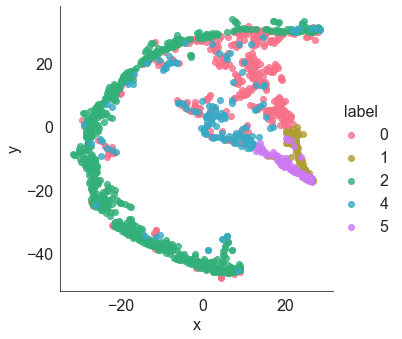

In [14]:
facet = sns.lmplot(data=vis_df, x='x', y='y', hue='label', 
                   fit_reg=False, legend=True, legend_out=True)

In [15]:
pd.DataFrame(vis_df["label_"].value_counts())

,label_
non-bot,1125
bot,127


/home/artem/Desktop/made/classenv/lib/python3.8/site-packages/seaborn/regression.py:592: UserWarning: legend_out is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


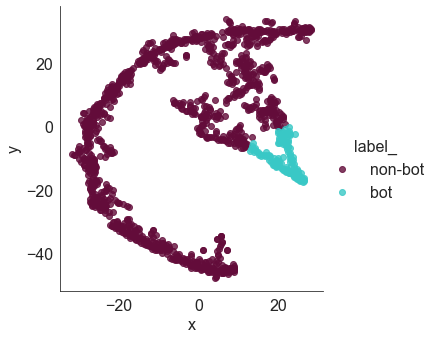

In [16]:
facet = sns.lmplot(data=vis_df, x='x', y='y', hue='label_', 
                   fit_reg=False, legend=True, legend_out=True)

## Results interpretation

In [17]:
all_nodes = np.concatenate((train_nodes, test_nodes, val_nodes))
for label in vis_df["label"].unique():
    k = 0
    found_nodes = []
    for i, idx in enumerate(list(vis_df[vis_df["label"] == label].index)):
        # print(all_nodes[idx], k)
        if f"VK_{all_nodes[idx]}" in bots:
            k += 1
            found_nodes.append(all_nodes[idx])
    print(label, "label: ",  k, "items:", found_nodes)

0 label:  1 items: ['127733082']
1 label:  0 items: []
2 label:  0 items: []
4 label:  0 items: []
5 label:  1 items: ['115255023']


Unfortunately, very few accounts, that were taken in this particular approach, belonged to the dataset of bots. So, although, 2 clusters were built, and sampling accounts from both groups and manually following them proved us that the approach is generally correct, it could only be taken for as an approve, that it is possible to detect automatically managed accounts algorithmically (what we will do further).